In [21]:
import tensorflow.compat.v1 as tf
from tensorflow import feature_column
from tensorflow.keras import layers
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential # 케라스의 Sequential()을 임포트
from tensorflow.keras.layers import Dense # 케라스의 Dense()를 임포트
from tensorflow.keras import optimizers # 케라스의 옵티마이저를 임포트
%matplotlib inline

In [22]:
#doginfo.csv파일 데이터를 pandas를 이용해 읽어옵니다.
dog_data=pd.read_csv("doginfo_mmy.csv")
dog_train=pd.read_csv("testDog.csv")
kindCd=pd.read_csv("kindCd.csv")

dog_data = dog_data.dropna(axis=0)
dog_train = dog_train.dropna(axis=0)
kindCd_data = kindCd.dropna(axis=0)
dog_train

,kindNum,neuterYn,sexCd,weight,noticeDays,age2,processState
0,128.0,N,M,0.8,10,0,1
1,114.0,N,M,5.0,10,1,0
2,12.0,N,F,5.0,10,13,0
3,17.0,N,M,5.0,10,3,0
4,114.0,N,M,15.0,10,7,0
...,...,...,...,...,...,...,...
606,77.0,Y,M,6.4,11,10,0
607,114.0,U,F,1.7,11,0,0
608,114.0,U,F,1.7,11,0,1
609,72.0,U,F,3.6,11,2,1


In [23]:
kindCd = np.array(kindCd_data, dtype = np.float64)
kindCd_train=np.array(kindCd_data, dtype=np.float64)

kindCd = kindCd.reshape(177)
kindCd_train=kindCd_train.reshape(177)
print(kindCd)
print(kindCd.shape)

[ 54.  56.  55. 118. 115.  37.  81. 204.  83.  82.  38.  39.  40.  43.
  42. 153.  41. 120. 155.  69.  71. 142.  93. 167.  70. 166.  94. 121.
 152.  73. 146.  72. 159.  76.  75.  79.  78.  77.  74.  80. 114. 133.
  12.  17.  15. 164. 157. 148.  16.  20.  21.  22.  24. 208.  23.  26.
  27. 169.  25.  19.  13.  18.  14. 162.  85.  96.  95.   1.  34. 104.
  31.  99. 122. 123.  97. 132. 105. 154. 124. 100. 103. 151. 139. 101.
 102.  98. 136. 202. 160. 203.   8. 131.   9. 119. 150. 210.  57.  58.
  59.   6.   4.   7.   5. 143.  11.  10. 137.  84. 163. 112. 113. 149.
 211. 110. 205. 108. 109.  60.  46.  47.  44.  45.  53.  62.  61.  52.
 165.  51. 156. 129.  67.  35.  33.  32. 158. 144.  30.  29.  64. 207.
  28.   2.  68. 125. 141. 145.  36.  66.  65.  63. 140. 107. 106. 209.
  86.  88.  90.  87. 138.  89. 126. 127. 128.  91.   3. 161.  50. 168.
  49. 147.  92.  48. 135. 206. 130. 134. 111.]
(177,)


In [24]:
# kindNum을 원핫 인코딩
kindCd = pd.concat((pd.get_dummies(dog_data.kindNum, columns=kindCd), pd.DataFrame(columns=kindCd))).fillna(0)


# 학습데이터에서 kindNum 열을 삭제한 후, 원핫 인코딩된 kindCd를 붙임
dog_data.drop(['kindNum'], axis='columns', inplace=True)
dog_data = pd.concat([dog_data, kindCd], axis=1)


# kindNum을 원핫 인코딩
kindCd_train = pd.concat((pd.get_dummies(dog_train.kindNum, columns=kindCd_train), pd.DataFrame(columns=kindCd_train))).fillna(0)

# 테스트데이터에서 kindNum 열을 삭제한 후, 원핫 인코딩된 kindCd를 붙임
dog_train.drop(['kindNum'], axis='columns', inplace=True)
dog_train = pd.concat([dog_train, kindCd_train], axis=1)


In [25]:
def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis = 1)
        data = data.drop(column, axis = 1)
    return data

In [26]:
dummy_columns = ["neuterYn", "sexCd"]
data = dummy_data(dog_data, dummy_columns)
train_data = dummy_data(dog_train, dummy_columns)

print(data)

data = np.array(data, dtype = np.float64)
train_data = np.array(train_data, dtype = np.float64)


      weight  noticeDays  age2  processState  1.0  2.0  3.0  4.0  5.0  6.0  \
0       7.46          10    12             0    0    0    0    0    0    0   
1       7.00          14     1             1    0    0    0    0    0    0   
2       4.50          11     2             0    0    0    0    0    0    0   
3      10.00           8     1             0    0    0    0    0    0    0   
4       6.00           8     4             0    0    0    0    0    0    0   
...      ...         ...   ...           ...  ...  ...  ...  ...  ...  ...   
1994    0.98          10     0             1    0    0    0    0    0    0   
1995    1.20          10     0             1    0    0    0    0    0    0   
1996   50.00          10     3             1    0    0    0    0    0    0   
1997    9.00          10     3             0    0    0    0    0    0    0   
1998   12.50          10     3             0    0    0    0    0    0    0   

      ...  208.0  209.0  210.0  211.0  neuterYn_N  neuterYn_U  

In [27]:
a = data[:, :3]
b = data[:, 4:]

#numpy 배열에서 데이터 변화요인(kindCd, neuterYn, sexCd, weight, noticeDays, age2)으로 사용할 데이터를 뽑아냅니다.
xData = np.concatenate([a, b], axis = 1)

a=train_data[:, :3]
b=train_data[:, 4:]
testX=np.concatenate([a, b], axis = 1)


In [28]:
#numpy배열에서 결과(입양여부)로 사용할 데이터를 뽑아냅니다.
yData=data[:,[3]]
testY=train_data[:,[3]]

print(yData)
type(yData)
yData.dtype

[[0.]
 [1.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]


dtype('float64')

Train on 1995 samples, validate on 610 samples
Epoch 1/100
1995/1995 [==============================] - 1s 359us/sample - loss: 0.8601 - acc: 0.5794 - binary_crossentropy: 0.6813 - val_loss: 0.7481 - val_acc: 0.5574 - val_binary_crossentropy: 0.6783
Epoch 2/100
1995/1995 [==============================] - 0s 243us/sample - loss: 0.7083 - acc: 0.6271 - binary_crossentropy: 0.6565 - val_loss: 0.7023 - val_acc: 0.5934 - val_binary_crossentropy: 0.6604
Epoch 3/100
1995/1995 [==============================] - 0s 227us/sample - loss: 0.6765 - acc: 0.6401 - binary_crossentropy: 0.6379 - val_loss: 0.6888 - val_acc: 0.5902 - val_binary_crossentropy: 0.6523
Epoch 4/100
1995/1995 [==============================] - 1s 280us/sample - loss: 0.6605 - acc: 0.6571 - binary_crossentropy: 0.6249 - val_loss: 0.7084 - val_acc: 0.6230 - val_binary_crossentropy: 0.6733
Epoch 5/100
1995/1995 [==============================] - 1s 370us/sample - loss: 0.6493 - acc: 0.6662 - binary_crossentropy: 0.6142 - val_los

Epoch 41/100
1995/1995 [==============================] - 1s 284us/sample - loss: 0.6044 - acc: 0.6887 - binary_crossentropy: 0.5807 - val_loss: 0.7013 - val_acc: 0.6262 - val_binary_crossentropy: 0.6776
Epoch 42/100
1995/1995 [==============================] - 1s 355us/sample - loss: 0.6039 - acc: 0.6887 - binary_crossentropy: 0.5803 - val_loss: 0.6806 - val_acc: 0.6377 - val_binary_crossentropy: 0.6572
Epoch 43/100
1995/1995 [==============================] - 1s 324us/sample - loss: 0.6051 - acc: 0.6812 - binary_crossentropy: 0.5817 - val_loss: 0.6902 - val_acc: 0.6213 - val_binary_crossentropy: 0.6670
Epoch 44/100
1995/1995 [==============================] - 1s 305us/sample - loss: 0.6056 - acc: 0.6887 - binary_crossentropy: 0.5826 - val_loss: 0.6964 - val_acc: 0.6246 - val_binary_crossentropy: 0.6736
Epoch 45/100
1995/1995 [==============================] - 1s 262us/sample - loss: 0.6026 - acc: 0.6932 - binary_crossentropy: 0.5795 - val_loss: 0.7138 - val_acc: 0.6262 - val_binary_c

1995/1995 [==============================] - 1s 336us/sample - loss: 0.5988 - acc: 0.6907 - binary_crossentropy: 0.5792 - val_loss: 0.6782 - val_acc: 0.6393 - val_binary_crossentropy: 0.6582
Epoch 82/100
1995/1995 [==============================] - 1s 294us/sample - loss: 0.5972 - acc: 0.6967 - binary_crossentropy: 0.5774 - val_loss: 0.7118 - val_acc: 0.6295 - val_binary_crossentropy: 0.6919
Epoch 83/100
1995/1995 [==============================] - 0s 221us/sample - loss: 0.5983 - acc: 0.6937 - binary_crossentropy: 0.5783 - val_loss: 0.6873 - val_acc: 0.6262 - val_binary_crossentropy: 0.6674
Epoch 84/100
1995/1995 [==============================] - 0s 204us/sample - loss: 0.5938 - acc: 0.6922 - binary_crossentropy: 0.5736 - val_loss: 0.6885 - val_acc: 0.6328 - val_binary_crossentropy: 0.6685
Epoch 85/100
1995/1995 [==============================] - 0s 207us/sample - loss: 0.5954 - acc: 0.7033 - binary_crossentropy: 0.5755 - val_loss: 0.6865 - val_acc: 0.6295 - val_binary_crossentropy: 

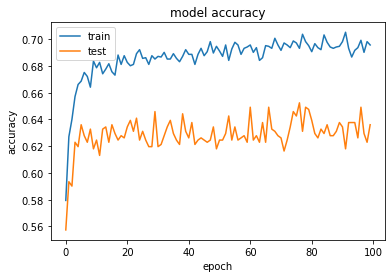

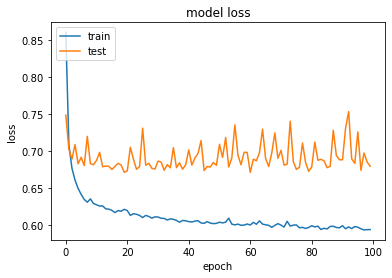

In [30]:
# L2규제만
l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.01),
                       activation=tf.nn.relu, input_shape=(186,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.01),
                       activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
sgd=optimizers.SGD(lr=0.01)
adam=optimizers.Adam(lr=0.01)
l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model_history = l2_model.fit(xData, yData,
                                epochs=100,
                                batch_size=10,
                                validation_data=(testX, testY),
                                verbose=1)
## summarize history for accuracy
plt.plot(l2_model_history.history['acc'])
plt.plot(l2_model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
## summarize history for loss
plt.plot(l2_model_history.history['loss'])
plt.plot(l2_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# l2_model.fit(xData, yData,epochs=100,batch_size=64,validation_data=(xData, yData),verbose=1)
# loss_and_metric = l2_model.evaluate(testX, testY, batch_size=10, verbose=0)
# print("train, loss and metric: {}".format(loss_and_metric))

# l2_model.summary()

In [31]:
# 드롭아웃만

dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(186,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

sgd=optimizers.SGD(lr=0.01)
adam=optimizers.Adam(lr=0.01)
# l2_model.compile(optimizer='sgd',
#                  loss='binary_crossentropy',
#                  metrics=['accuracy', 'binary_crossentropy'])


dpt_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','binary_crossentropy'])

dpt_model_history = dpt_model.fit(xData, yData,
                                  epochs=100,
                                  batch_size=10,
                                  validation_data=(testX, testY),
                                  verbose=1)

loss_and_metric = l2_model.evaluate(testX, testY, batch_size=10, verbose=0)
print("train, loss and metric: {}".format(loss_and_metric))

Train on 1995 samples, validate on 610 samples
Epoch 1/100
1995/1995 [==============================] - 1s 431us/sample - loss: 0.7486 - acc: 0.5333 - binary_crossentropy: 0.7486 - val_loss: 0.6791 - val_acc: 0.5443 - val_binary_crossentropy: 0.6791
Epoch 2/100
1995/1995 [==============================] - 1s 272us/sample - loss: 0.6792 - acc: 0.5860 - binary_crossentropy: 0.6792 - val_loss: 0.6649 - val_acc: 0.5967 - val_binary_crossentropy: 0.6649
Epoch 3/100
1995/1995 [==============================] - 1s 264us/sample - loss: 0.6616 - acc: 0.6060 - binary_crossentropy: 0.6616 - val_loss: 0.6602 - val_acc: 0.6131 - val_binary_crossentropy: 0.6602
Epoch 4/100
1995/1995 [==============================] - 0s 246us/sample - loss: 0.6499 - acc: 0.6386 - binary_crossentropy: 0.6499 - val_loss: 0.6535 - val_acc: 0.6148 - val_binary_crossentropy: 0.6535
Epoch 5/100
1995/1995 [==============================] - 1s 304us/sample - loss: 0.6395 - acc: 0.6336 - binary_crossentropy: 0.6395 - val_los

Epoch 41/100
1995/1995 [==============================] - 0s 236us/sample - loss: 0.5702 - acc: 0.7063 - binary_crossentropy: 0.5702 - val_loss: 0.7017 - val_acc: 0.6459 - val_binary_crossentropy: 0.7017
Epoch 42/100
1995/1995 [==============================] - 1s 297us/sample - loss: 0.5638 - acc: 0.7038 - binary_crossentropy: 0.5638 - val_loss: 0.7026 - val_acc: 0.6311 - val_binary_crossentropy: 0.7026
Epoch 43/100
1995/1995 [==============================] - 1s 366us/sample - loss: 0.5675 - acc: 0.7033 - binary_crossentropy: 0.5675 - val_loss: 0.6785 - val_acc: 0.6311 - val_binary_crossentropy: 0.6785
Epoch 44/100
1995/1995 [==============================] - 1s 408us/sample - loss: 0.5660 - acc: 0.7028 - binary_crossentropy: 0.5660 - val_loss: 0.6874 - val_acc: 0.6361 - val_binary_crossentropy: 0.6874
Epoch 45/100
1995/1995 [==============================] - 1s 394us/sample - loss: 0.5630 - acc: 0.7118 - binary_crossentropy: 0.5630 - val_loss: 0.6725 - val_acc: 0.6492 - val_binary_c

1995/1995 [==============================] - 1s 348us/sample - loss: 0.5524 - acc: 0.7228 - binary_crossentropy: 0.5524 - val_loss: 0.7285 - val_acc: 0.6475 - val_binary_crossentropy: 0.7285
Epoch 82/100
1995/1995 [==============================] - 1s 254us/sample - loss: 0.5546 - acc: 0.7078 - binary_crossentropy: 0.5546 - val_loss: 0.7236 - val_acc: 0.6508 - val_binary_crossentropy: 0.7236
Epoch 83/100
1995/1995 [==============================] - 1s 309us/sample - loss: 0.5522 - acc: 0.7068 - binary_crossentropy: 0.5522 - val_loss: 0.7335 - val_acc: 0.6426 - val_binary_crossentropy: 0.7335
Epoch 84/100
1995/1995 [==============================] - 1s 334us/sample - loss: 0.5586 - acc: 0.7053 - binary_crossentropy: 0.5586 - val_loss: 0.7739 - val_acc: 0.6459 - val_binary_crossentropy: 0.7739
Epoch 85/100
1995/1995 [==============================] - 1s 255us/sample - loss: 0.5475 - acc: 0.7153 - binary_crossentropy: 0.5475 - val_loss: 0.7874 - val_acc: 0.6393 - val_binary_crossentropy: 

In [19]:
# L2규제, 드롭아웃 모두 적용

l2_dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.01),
                       activation=tf.nn.relu, input_shape=(186,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.01),
                       activation=tf.nn.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
]) 
adam=optimizers.Adam(lr=0.01)
sgd=optimizers.SGD(lr=0.01)
l2_dpt_model.compile(optimizer=sgd,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

l2_model.fit(xData, yData,epochs=100,batch_size=10,validation_data=(testX, testY),verbose=1)
loss_and_metric = l2_dpt_model.evaluate(testX, testY, batch_size=10, verbose=0)
print("train, loss and metric: {}".format(loss_and_metric))

Train on 1995 samples, validate on 610 samples
Epoch 1/100
1995/1995 [==============================] - 0s 200us/sample - loss: 0.6284 - acc: 0.6752 - binary_crossentropy: 0.6016 - val_loss: 0.7179 - val_acc: 0.6213 - val_binary_crossentropy: 0.6911
Epoch 2/100
1995/1995 [==============================] - 0s 195us/sample - loss: 0.6289 - acc: 0.6757 - binary_crossentropy: 0.6020 - val_loss: 0.7043 - val_acc: 0.6213 - val_binary_crossentropy: 0.6771
Epoch 3/100
1995/1995 [==============================] - 0s 190us/sample - loss: 0.6330 - acc: 0.6742 - binary_crossentropy: 0.6058 - val_loss: 0.7263 - val_acc: 0.6230 - val_binary_crossentropy: 0.6996
Epoch 4/100
1995/1995 [==============================] - 0s 186us/sample - loss: 0.6246 - acc: 0.6797 - binary_crossentropy: 0.5978 - val_loss: 0.6985 - val_acc: 0.6344 - val_binary_crossentropy: 0.6716
Epoch 5/100
1995/1995 [==============================] - 0s 196us/sample - loss: 0.6308 - acc: 0.6617 - binary_crossentropy: 0.6039 - val_los

Epoch 41/100
1995/1995 [==============================] - 0s 196us/sample - loss: 0.6275 - acc: 0.6627 - binary_crossentropy: 0.6010 - val_loss: 0.7082 - val_acc: 0.6246 - val_binary_crossentropy: 0.6819
Epoch 42/100
1995/1995 [==============================] - 0s 166us/sample - loss: 0.6284 - acc: 0.6847 - binary_crossentropy: 0.6022 - val_loss: 0.6872 - val_acc: 0.6197 - val_binary_crossentropy: 0.6608
Epoch 43/100
1995/1995 [==============================] - 0s 172us/sample - loss: 0.6293 - acc: 0.6757 - binary_crossentropy: 0.6029 - val_loss: 0.7769 - val_acc: 0.5934 - val_binary_crossentropy: 0.7508
Epoch 44/100
1995/1995 [==============================] - 0s 182us/sample - loss: 0.6261 - acc: 0.6787 - binary_crossentropy: 0.6000 - val_loss: 0.6823 - val_acc: 0.6410 - val_binary_crossentropy: 0.6561
Epoch 45/100
1995/1995 [==============================] - 0s 179us/sample - loss: 0.6253 - acc: 0.6737 - binary_crossentropy: 0.5992 - val_loss: 0.6886 - val_acc: 0.6311 - val_binary_c

1995/1995 [==============================] - 0s 233us/sample - loss: 0.6289 - acc: 0.6752 - binary_crossentropy: 0.6025 - val_loss: 0.7162 - val_acc: 0.6262 - val_binary_crossentropy: 0.6898
Epoch 82/100
1995/1995 [==============================] - 0s 248us/sample - loss: 0.6224 - acc: 0.6862 - binary_crossentropy: 0.5962 - val_loss: 0.6810 - val_acc: 0.6328 - val_binary_crossentropy: 0.6549
Epoch 83/100
1995/1995 [==============================] - 1s 278us/sample - loss: 0.6255 - acc: 0.6712 - binary_crossentropy: 0.5991 - val_loss: 0.7031 - val_acc: 0.6033 - val_binary_crossentropy: 0.6766
Epoch 84/100
1995/1995 [==============================] - 1s 273us/sample - loss: 0.6268 - acc: 0.6702 - binary_crossentropy: 0.6004 - val_loss: 0.6777 - val_acc: 0.6279 - val_binary_crossentropy: 0.6514
Epoch 85/100
1995/1995 [==============================] - 1s 259us/sample - loss: 0.6268 - acc: 0.6702 - binary_crossentropy: 0.6004 - val_loss: 0.6913 - val_acc: 0.6295 - val_binary_crossentropy: 

In [15]:
for i in range(len(train_data)):
    new_x=train_data[i, :].reshape(1,186)
    print('입양 확률 : %8.4f%%' % (l2_model.predict(new_x)*100))
l2_model.save('l2_model')

입양 확률 :  94.2203%
입양 확률 :  36.7390%
입양 확률 :  35.8996%
입양 확률 :  78.0932%
입양 확률 :  21.0893%
입양 확률 :  21.0893%
입양 확률 :  91.3862%
입양 확률 :  78.4416%
입양 확률 :  89.5666%
입양 확률 :  84.8468%
입양 확률 :  72.6395%
입양 확률 :  85.3167%
입양 확률 :  55.5937%
입양 확률 :  49.5257%
입양 확률 :  51.3644%
입양 확률 :  28.9706%
입양 확률 :  44.0449%
입양 확률 :  37.9210%
입양 확률 :  83.8701%
입양 확률 :  23.1563%
입양 확률 :  64.8517%
입양 확률 :  64.8517%
입양 확률 :  53.8228%
입양 확률 :  46.9142%
입양 확률 :  71.4867%
입양 확률 :  58.0059%
입양 확률 :  54.1604%
입양 확률 :  57.8769%
입양 확률 :  41.1052%
입양 확률 :  54.8027%
입양 확률 :  56.1087%
입양 확률 :  41.1052%
입양 확률 :  40.0840%
입양 확률 :  37.2096%
입양 확률 :  90.8167%
입양 확률 :  88.6520%
입양 확률 :  19.2490%
입양 확률 :  69.2019%
입양 확률 :  76.6373%
입양 확률 :  28.4616%
입양 확률 :  26.2082%
입양 확률 :  37.8162%
입양 확률 :  49.3927%
입양 확률 :  31.0500%
입양 확률 :  32.5425%
입양 확률 :  45.5628%
입양 확률 :  49.3927%
입양 확률 :  51.3507%
입양 확률 :  36.3324%
입양 확률 :  45.9654%
입양 확률 :  29.5362%
입양 확률 :  29.1457%
입양 확률 :  55.1988%
입양 확률 :  52.2923%
입양 확률 :  54.0260%
입양 확률 :  5

입양 확률 :  28.6237%
입양 확률 :  93.3353%
입양 확률 :  32.6441%
입양 확률 :  37.7122%
입양 확률 :  67.2223%
입양 확률 :  23.0380%
입양 확률 :  70.3892%
입양 확률 :  77.7126%
입양 확률 :  55.1501%
입양 확률 :  57.7917%
입양 확률 :  67.0752%
입양 확률 :  32.6870%
입양 확률 :  88.6794%
입양 확률 :  50.1714%
입양 확률 :  34.4334%
입양 확률 :  30.2486%
입양 확률 :  57.1593%
입양 확률 :  53.8719%
입양 확률 :  71.0483%
입양 확률 :  66.8481%
입양 확률 :  83.2895%
입양 확률 :  59.9851%
입양 확률 :  87.3223%
입양 확률 :  94.8906%
입양 확률 :  53.2306%
입양 확률 :  41.5467%
입양 확률 :  41.7502%
입양 확률 :  26.5065%
입양 확률 :  29.7671%
입양 확률 :  96.1752%
입양 확률 :  44.4502%
입양 확률 :  92.8657%
입양 확률 :  39.4909%
입양 확률 :  83.0424%
입양 확률 :  91.3181%
입양 확률 :  86.7357%
입양 확률 :  54.5117%
입양 확률 :  23.3083%
입양 확률 :  24.4934%
입양 확률 :  90.5356%
입양 확률 :  65.2899%
입양 확률 :  32.4555%
입양 확률 :  20.8052%
입양 확률 :  31.4452%
입양 확률 :  50.1362%
입양 확률 :  52.8710%
입양 확률 :  53.2796%
입양 확률 :  53.4489%
입양 확률 :  85.6347%
입양 확률 :  89.7685%
입양 확률 :  30.2853%
입양 확률 :  57.8625%
입양 확률 :  33.0917%
입양 확률 :  52.3523%
입양 확률 :  90.5433%
입양 확률 :  9